# ImageNet Neural Network Analysis

## Environment Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import tensorflow as tf
import os
import shutil
import numpy as np
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import layers
from keras import models
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
CLASSES = ['Paul_Gauguin',
 'Edgar_Degas',
 'Vincent_van_Gogh',
 'Albrecht_Dürer',
 'Pablo_Picasso',
 'Titian',
 'Francisco_Goya',
 'Marc_Chagall',
 'Pierre-Auguste_Renoir',
 'Alfred_Sisley',
 'Rembrandt']

TRAIN_DIR = '/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/Split-dataset/train'
TEST_DIR = '/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/Split-dataset/test'
VAL_DIR = '/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/Split-dataset/val'

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32
RANDOM_SEED = 47

MODEL_DIR = "/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/InceptionNet"

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

LOCAL_PATH = "/content/model"

if not os.path.exists(LOCAL_PATH):
    os.makedirs(LOCAL_PATH)

## Compute class weights

In [4]:
GENERAL_PATH="/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/Split-dataset/train"

class_cardinality={}
for it in os.scandir(GENERAL_PATH):
    if it.is_dir():
      class_cardinality[it.name]=len(os.listdir(it.path))

df = pd.DataFrame(class_cardinality.items(), columns=['Name', 'Num_Paintings'])
df["Class_Weight"] = df.Num_Paintings.sum() / (len(CLASSES)*df.Num_Paintings)
CLASS_WEIGHTS = df['Class_Weight'].to_dict()
CLASS_WEIGHTS

{0: 1.258483452031839,
 1: 0.556193297537493,
 2: 0.44549903603737206,
 3: 1.1925367209210005,
 4: 0.889546935149541,
 5: 1.5342185903983656,
 6: 1.3452754142409316,
 7: 1.6352749047359825,
 8: 1.1620889748549323,
 9: 1.508789552988448,
 10: 1.4923000496770988}

## Utility funciton to reuse snippet of code

In [5]:
def model_compiler(model, learning_rate = 0.001, my_loss = "sparse_categorical_crossentropy", my_optimizer = "Adam", my_metrics = "accuracy"):
  
  custom_opt = optimizers.Adam(learning_rate=learning_rate)
  
  model.compile(loss = my_loss, optimizer = custom_opt, metrics = [my_metrics])
  return model

def model_executor(model, model_name, train, validation, epoch_number = 20, patience = 2, class_weights = None):
  model_path = LOCAL_PATH + "/" + model_name + ".h5"
  callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience),
      keras.callbacks.ModelCheckpoint(filepath = model_path, monitor="val_loss", verbose=1, save_best_only=True)
  ]

  train_history = model.fit(train, validation_data = validation, epochs=epoch_number, callbacks = callbacks, class_weight = class_weights)

  shutil.copy(model_path, MODEL_DIR + "/" + model_name + ".h5")

  return model, train_history

def model_evaluator(model, test):
  model.evaluate(test)

  true_labels = np.concatenate([y for x, y in test], axis=0)
  pred_labels = model.predict(test)
  pred_labels = np.argmax(pred_labels, axis=-1)
  print(classification_report(true_labels, pred_labels, target_names = CLASSES))
  return pred_labels

def confusion_matrix_maker(model, test, pred_labels):

  true_labels = np.concatenate([y for x, y in test], axis=0)
  fig, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, xticks_rotation='vertical', ax=ax, display_labels=CLASSES)

def plot_train_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def plot_model_structure(model, name):
  tf.keras.utils.plot_model(model, to_file=name+'.png', show_shapes=True, show_layer_names=True)

## Dataset Loading

In [6]:
training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=False,
    seed=RANDOM_SEED
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

Found 3004 files belonging to 11 classes.
Found 656 files belonging to 11 classes.
Found 639 files belonging to 11 classes.


## Inception network with custom classifier

In [ ]:
inception_net = tf.keras.applications.inception_v3.InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

inception_net.trainable = False
inception_net.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.inception_v3.preprocess_input(inputs)
x = inception_net(x)

x = layers.Flatten(name='flatten')(x)


x = layers.Dense(1024,activation='relu', name='classifier_hidden_1')(x)
x = layers.Dense(512,activation='relu', name='classifier_hidden_2')(x)

output = layers.Dense(len(CLASSES), activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=output, name="inception_net")


model = model_compiler(model, learning_rate=0.0001)
model.summary()

Model: "inception_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 classifier_hidden_1 (Dense)  (None, 1024)           

In [ ]:
model, history = model_executor(model, "Inception_NoDropout", training_images, val_images, 20, 5, CLASS_WEIGHTS)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 1.9673 - accuracy: 0.4667
Epoch 1: val_loss improved from inf to 1.10177, saving model to /content/model/Inception_NoDropout.h5
94/94 [==============================] - 29s 179ms/step - loss: 1.9673 - accuracy: 0.4667 - val_loss: 1.1018 - val_accuracy: 0.6275
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 0.5864 - accuracy: 0.8126
Epoch 2: val_loss improved from 1.10177 to 0.96141, saving model to /content/model/Inception_NoDropout.h5
94/94 [==============================] - 14s 140ms/step - loss: 0.5864 - accuracy: 0.8126 - val_loss: 0.9614 - val_accuracy: 0.6839
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 0.2425 - accuracy: 0.9244
Epoch 3: val_loss did not improve from 0.96141
94/94 [==============================] - 11s 111ms/step - loss: 0.2425 - accuracy: 0.9244 - val_loss: 1.1351 - val_accuracy: 0.6604
Epoch 4/20
94/94 [==============================] - ETA: 0s - loss:

Plots of accuracy and loss during training, these can help to recognize overfitting

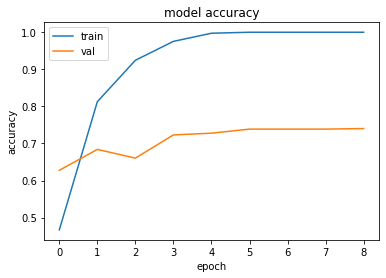

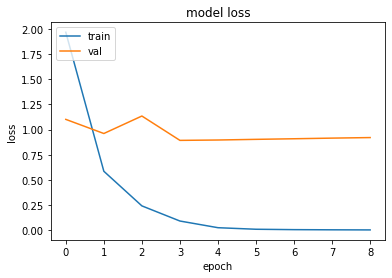

In [ ]:
plot_train_history(history)

In [ ]:
pred_labels = model_evaluator(model, test_images)

21/21 [==============================] - 4s 90ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.86      0.96      0.91        50
          Edgar_Degas       0.87      0.85      0.86        40
     Vincent_van_Gogh       0.82      0.88      0.85       106
       Albrecht_Dürer       0.71      0.67      0.69        45
        Pablo_Picasso       0.76      0.68      0.71        37
               Titian       0.69      0.67      0.68        67
       Francisco_Goya       0.69      0.56      0.62        48
         Marc_Chagall       0.67      0.61      0.64        51
Pierre-Auguste_Renoir       0.69      0.72      0.71        40
        Alfred_Sisley       0.67      0.74      0.71        39
            Rembrandt       0.75      0.78      0.77       133

             accuracy                           0.75       656
            macro avg       0.75      0.74      0.74       656
         weighted avg       0.75      0.75      0.75       656

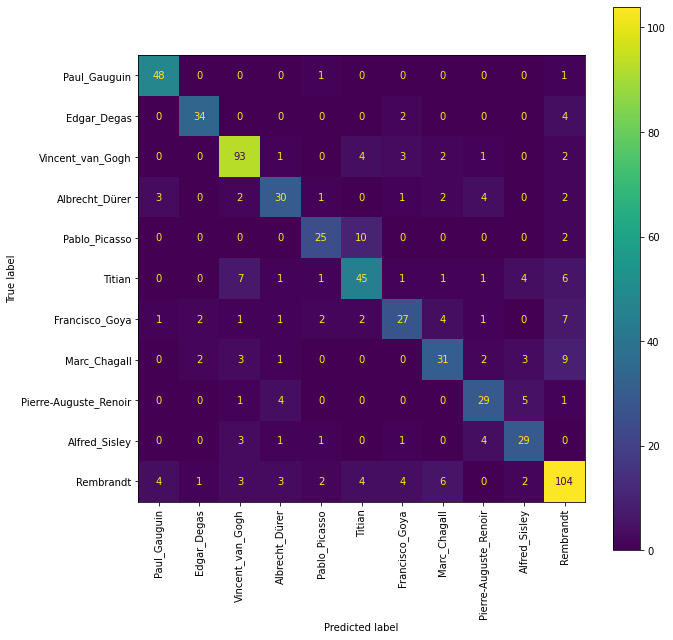

In [ ]:
confusion_matrix_maker(model, test_images, pred_labels)

In [ ]:
plot_model_structure(model, "Inception_NoDropout")

## Inception with Dropout

In [ ]:
inception = tf.keras.applications.inception_v3.InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

inception.trainable = False
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 111, 111, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                      

We decided to add a dropout layer after each layer to prevent overfitting

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.inception_v3.preprocess_input(inputs)
x = inception(x)

x = layers.Flatten(name='flatten')(x)
x = layers.Dense(1024,activation='relu', name='classifier_hidden_1')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(512,activation='relu', name='classifier_hidden_2')(x)
output = layers.Dense(len(CLASSES), activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=output, name="Inception_Dropout")


model = model_compiler(model)
model.summary()

Model: "Inception_Dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 classifier_hidden_1 (Dense)  (None, 1024)       

In [ ]:
model, history = model_executor(model, "Dropout", training_images, val_images, 20, 3, CLASS_WEIGHTS)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 9.6553 - accuracy: 0.3562
Epoch 1: val_loss improved from inf to 1.27668, saving model to /content/model/Dropout.h5
94/94 [==============================] - 21s 171ms/step - loss: 9.6553 - accuracy: 0.3562 - val_loss: 1.2767 - val_accuracy: 0.5634
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 0.6721
Epoch 2: val_loss improved from 1.27668 to 1.10059, saving model to /content/model/Dropout.h5
94/94 [==============================] - 15s 157ms/step - loss: 1.0439 - accuracy: 0.6721 - val_loss: 1.1006 - val_accuracy: 0.6416
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 0.5482 - accuracy: 0.8242
Epoch 3: val_loss improved from 1.10059 to 1.09444, saving model to /content/model/Dropout.h5
94/94 [==============================] - 15s 155ms/step - loss: 0.5482 - accuracy: 0.8242 - val_loss: 1.0944 - val_accuracy: 0.6729
Epoch 4/20
94/94 [==========================

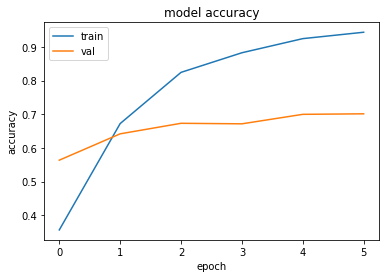

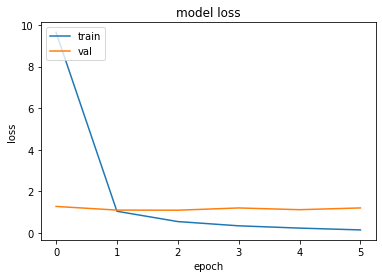

In [ ]:
plot_train_history(history)

In [ ]:
pred_labels = model_evaluator(model, test_images)

21/21 [==============================] - 4s 96ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.82      0.94      0.88        50
          Edgar_Degas       0.94      0.75      0.83        40
     Vincent_van_Gogh       0.85      0.78      0.81       106
       Albrecht_Dürer       0.60      0.47      0.52        45
        Pablo_Picasso       0.69      0.54      0.61        37
               Titian       0.79      0.40      0.53        67
       Francisco_Goya       0.55      0.48      0.51        48
         Marc_Chagall       0.80      0.63      0.70        51
Pierre-Auguste_Renoir       0.74      0.50      0.60        40
        Alfred_Sisley       0.46      0.87      0.60        39
            Rembrandt       0.59      0.83      0.69       133

             accuracy                           0.68       656
            macro avg       0.71      0.65      0.66       656
         weighted avg       0.71      0.68      0.68       656

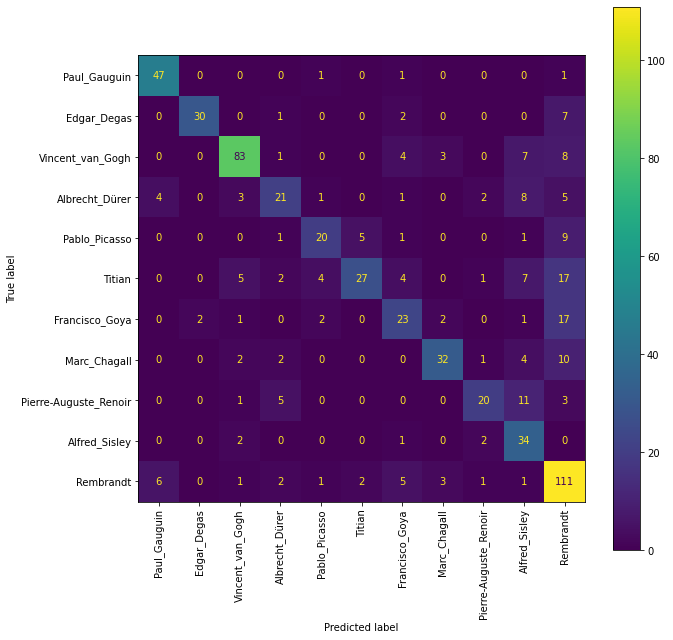

In [ ]:
confusion_matrix_maker(model, test_images, pred_labels)

In [ ]:
plot_model_structure(model, "Inception_Dropout")

## FineTuning

### Unfreezing conv5 block 3_3

In [ ]:
model = models.load_model('/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/InceptionNet/Inception_NoDropout.h5', compile=False)

In [ ]:
trainable = False
for layer in model.get_layer("inception_v3").layers:
    if 'conv2d_93' in layer.name:
        trainable = True

In [ ]:
model = model_compiler(model, 0.0001)
model.summary()

Model: "inception_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 classifier_hidden_1 (Dense)  (None, 1024)           

In [ ]:
model, history = model_executor(model, "Inc_FineTuning_block_3_3", training_images, val_images, 20, 6)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.9537
Epoch 1: val_loss improved from inf to 1.42378, saving model to /content/model/Inc_FineTuning_block_3_3.h5
94/94 [==============================] - 20s 157ms/step - loss: 0.1342 - accuracy: 0.9537 - val_loss: 1.4238 - val_accuracy: 0.6495
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 0.0918 - accuracy: 0.9717
Epoch 2: val_loss did not improve from 1.42378
94/94 [==============================] - 11s 108ms/step - loss: 0.0918 - accuracy: 0.9717 - val_loss: 1.4435 - val_accuracy: 0.6604
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 0.1081 - accuracy: 0.9660
Epoch 3: val_loss did not improve from 1.42378
94/94 [==============================] - 10s 107ms/step - loss: 0.1081 - accuracy: 0.9660 - val_loss: 1.5072 - val_accuracy: 0.6604
Epoch 4/20
94/94 [==============================] - ETA: 0s - loss: 0.0432 - accuracy: 0.9874
Epoch 4: val_loss did not i

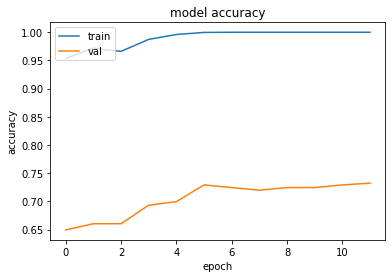

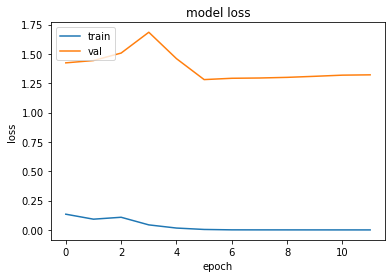

In [ ]:
plot_train_history(history)

In [ ]:
pred_labels = model_evaluator(model, test_images)

21/21 [==============================] - 3s 71ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.87      0.90      0.88        50
          Edgar_Degas       0.83      0.85      0.84        40
     Vincent_van_Gogh       0.77      0.92      0.84       106
       Albrecht_Dürer       0.65      0.62      0.64        45
        Pablo_Picasso       0.62      0.68      0.65        37
               Titian       0.66      0.61      0.64        67
       Francisco_Goya       0.77      0.48      0.59        48
         Marc_Chagall       0.64      0.59      0.61        51
Pierre-Auguste_Renoir       0.73      0.68      0.70        40
        Alfred_Sisley       0.72      0.72      0.72        39
            Rembrandt       0.72      0.75      0.74       133

             accuracy                           0.73       656
            macro avg       0.72      0.71      0.71       656
         weighted avg       0.73      0.73      0.72       656

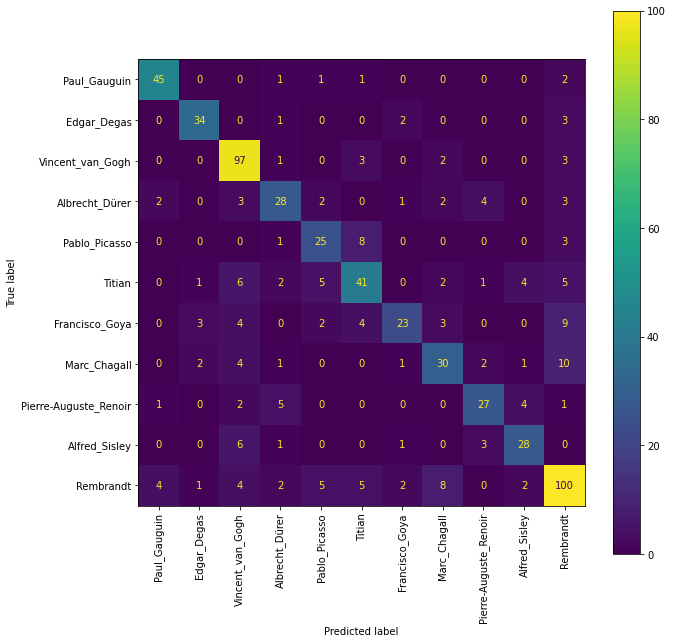

In [ ]:
confusion_matrix_maker(model, test_images, pred_labels)

### Unfreezing of the last layer  (classifier not trainable) learning_rate=0.000001

In [7]:
model = models.load_model('/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/InceptionNet/Inception_NoDropout.h5', compile=False)

In [8]:
trainable = False
for layer in model.get_layer("inception_v3").layers:
  if layer.name == 'conv2d_93':
      trainable = True
  layer.trainable = trainable

model.summary()

Model: "inception_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 classifier_hidden_1 (Dense)  (None, 1024)           

In [9]:
model.get_layer("classifier_hidden_1").trainable = False
model.get_layer("classifier_hidden_2").trainable = False
model.get_layer("dense").trainable = False
model.summary()
model = model_compiler(model, 0.000001)

Model: "inception_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 classifier_hidden_1 (Dense)  (None, 1024)           

In [10]:
model, history = model_executor(model, "Inc_fine_tuning_class_block", training_images, val_images, 20, 5)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9967 
Epoch 1: val_loss improved from inf to 0.90533, saving model to /content/model/Inc_fine_tuning_class_block.h5
94/94 [==============================] - 1341s 13s/step - loss: 0.0511 - accuracy: 0.9967 - val_loss: 0.9053 - val_accuracy: 0.7246
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9973
Epoch 2: val_loss did not improve from 0.90533
94/94 [==============================] - 9s 94ms/step - loss: 0.0503 - accuracy: 0.9973 - val_loss: 0.9220 - val_accuracy: 0.7167
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.9977
Epoch 3: val_loss did not improve from 0.90533
94/94 [==============================] - 10s 106ms/step - loss: 0.0494 - accuracy: 0.9977 - val_loss: 0.9280 - val_accuracy: 0.7152
Epoch 4/20
94/94 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9973
Epoch 4: val_loss did not

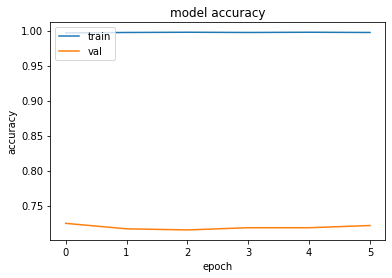

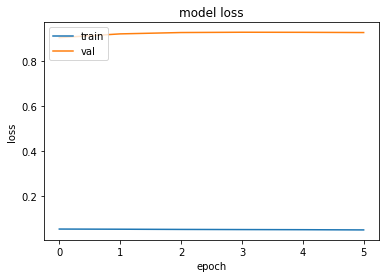

In [11]:
plot_train_history(history)

In [12]:
pred_labels = model_evaluator(model, test_images)

21/21 [==============================] - 3s 72ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.74      0.92      0.82        50
          Edgar_Degas       0.81      0.85      0.83        40
     Vincent_van_Gogh       0.83      0.80      0.81       106
       Albrecht_Dürer       0.57      0.67      0.61        45
        Pablo_Picasso       0.60      0.65      0.62        37
               Titian       0.63      0.72      0.67        67
       Francisco_Goya       0.67      0.50      0.57        48
         Marc_Chagall       0.58      0.59      0.58        51
Pierre-Auguste_Renoir       0.60      0.68      0.64        40
        Alfred_Sisley       0.58      0.77      0.66        39
            Rembrandt       0.84      0.60      0.70       133

             accuracy                           0.70       656
            macro avg       0.68      0.70      0.68       656
         weighted avg       0.71      0.70      0.70       656

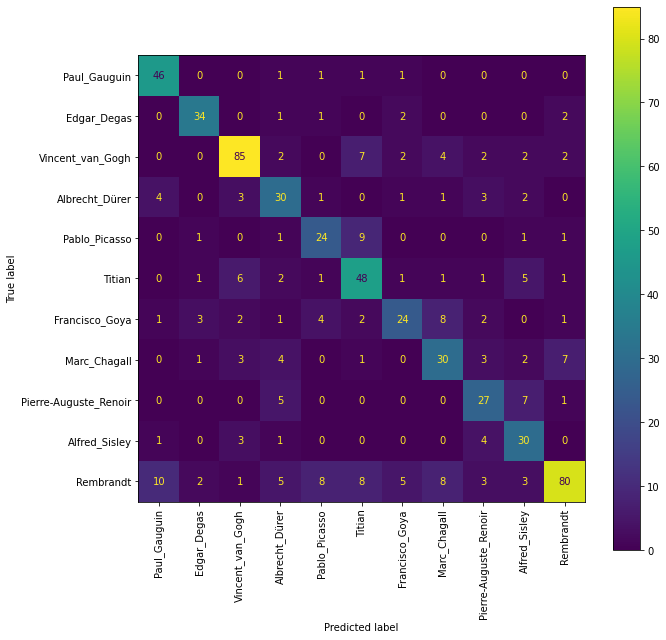

In [13]:
confusion_matrix_maker(model, test_images, pred_labels)